In [57]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

interim = '../data/interim'
br = pd.read_pickle(Path(interim) / 'batting_records.pkl')
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
events = pd.read_pickle(Path(interim) / 'events.pkl')
people = pd.read_pickle(Path(interim) / 'people.pkl')

## League DAta
League = events[events.BAT_FLD_CD != 1].groupby('year')[['HR', 'H', 'PA']].sum()
League.columns = ['League_HR', 'League_H', 'League_PA']
League['League_HPPA'] = (League['League_H'] / League['League_PA']).astype('float')

In [58]:
League = League.reset_index()

League['L1_League_HPPA'] = League['League_HPPA'].shift(1) 
League['L2_League_HPPA'] = League['League_HPPA'].shift(2)
League['L3_League_HPPA'] = League['League_HPPA'].shift(3)

<AxesSubplot:xlabel='year', ylabel='League_HPPA'>

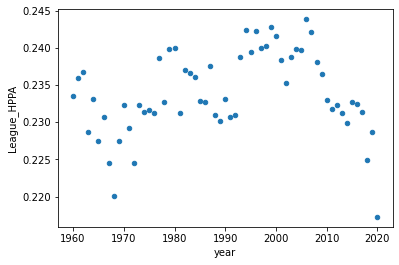

In [59]:
League[League.year >= 1960].plot.scatter('year', 'League_HPPA')

In [60]:
# limited = merged[(merged.G >= 50)  & (merged.prev_G >= 50)]
result = sm.ols(formula="League_HPPA ~ L1_League_HPPA + L2_League_HPPA + L3_League_HPPA", data=League).fit()
print(result.summary())
coef_const = result.params[0]
coef_L1_PA = result.params[1]
coef_L2_PA = result.params[2]

                            OLS Regression Results                            
Dep. Variable:            League_HPPA   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     124.8
Date:                Sun, 21 Mar 2021   Prob (F-statistic):           1.17e-32
Time:                        20:45:05   Log-Likelihood:                 390.36
No. Observations:                  98   AIC:                            -772.7
Df Residuals:                      94   BIC:                            -762.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0202      0.011      1.

In [71]:
x_vars = [
    'L1_League_HPPA', 'L2_League_HPPA', 'L3_League_HPPA'
]
preprocessor =  ColumnTransformer(
    [('spot', 'passthrough', x_vars)],
    remainder='drop'
)

clf = LassoCV(
    cv=5, random_state=0, max_iter=10000, n_jobs=-1,
)

fitted_model = Pipeline([
    ('select', preprocessor),
    ('poly', PolynomialFeatures(2, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', clf),
])

League = League.dropna()
fitted_model.fit(League, League['League_HPPA'].astype('float'))

Pipeline(steps=[('select',
                 ColumnTransformer(transformers=[('spot', 'passthrough',
                                                  ['L1_League_HPPA',
                                                   'L2_League_HPPA',
                                                   'L3_League_HPPA'])])),
                ('poly', PolynomialFeatures(interaction_only=True)),
                ('scale', StandardScaler()),
                ('clf',
                 LassoCV(cv=5, max_iter=10000, n_jobs=-1, random_state=0))])

In [72]:
League['pred'] = fitted_model.predict(League)

In [73]:
League['pred']

3      0.258765
4      0.258781
5      0.258848
6      0.261076
7      0.253762
         ...   
96     0.231938
97     0.232019
98     0.231835
99     0.228089
100    0.228888
Name: pred, Length: 98, dtype: float64

In [74]:
results = cross_val_score(fitted_model, League, League['League_HPPA'].astype('float'), cv=5, n_jobs=-1)

In [75]:
results

array([ 0.40417779, -0.76946357,  0.10564638,  0.42228819,  0.55293119])